In [29]:
import os
import numpy as np
import pandas as pd
import librosa
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
import torch
import torch.nn as nn
from torchviz import make_dot
from torchsummary import summary
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"
from torch.utils.data import DataLoader, TensorDataset


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print("Using device:", device)

Using device: cuda


In [31]:
# data_dir="C:/Users/divya/OneDrive/Documents/UTAUSTIN/Semester 6/460j/final_project_data/fma_small"
# file_path="C:/Users/divya/OneDrive/Documents/UTAUSTIN/Semester 6/460j/final_project_data/fma_small/000/000002.mp3"
#train_path = 'C:/Users/divya/OneDrive/Documents/UTAUSTIN/Semester6/460j/460jFinalProject/csvfiles/extracted_features_combined.csv'
train_path = 'C:/Users/divya/OneDrive/Documents/UTAUSTIN/Semester6/460j/460jFinalProject/csvfiles/extracted_features_wav2vec.csv'
torch.manual_seed(42)

data_df=pd.read_csv(train_path, index_col=0)
# data_df=pd.read_csv(train_path)


In [32]:
import torch
from torch import nn
from transformers import DistilBertModel, DistilBertConfig
from transformers import BertModel, BertConfig

# class GenreClassifier(nn.Module):
#     def __init__(self, input_dim, num_labels):
#         super(GenreClassifier, self).__init__()
#         self.bert_config = DistilBertConfig.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
#         self.bert = DistilBertModel(self.bert_config)
#         self.projection = nn.Linear(input_dim, self.bert.config.dim)
#         self.classifier = nn.Linear(self.bert.config.dim, num_labels)
#         self.dropout = nn.Dropout(0.1)

#     def forward(self, embeddings):
#         # Assume embeddings are [batch_size, embedding_dim], add a sequence length of 1
#         embeddings = embeddings.unsqueeze(1)  # Reshape to [batch_size, 1, embedding_dim]
#         embeddings = self.projection(embeddings)
#         outputs = self.bert(inputs_embeds=embeddings)
#         cls_output = outputs.last_hidden_state[:, 0, :]  # Use the output of the CLS token
#         cls_output = self.dropout(cls_output)
#         logits = self.classifier(cls_output)
#         return logits

class GenreClassifier(nn.Module):
    def __init__(self, input_dim, num_labels):
        super(GenreClassifier, self).__init__()
        self.bert_config = BertConfig.from_pretrained('bert-large-uncased', num_labels=num_labels)
        self.bert = BertModel(self.bert_config)
        self.projection = nn.Linear(input_dim, self.bert.config.hidden_size)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        self.dropout = nn.Dropout(0.1)

    def forward(self, embeddings):
        # Assume embeddings are [batch_size, embedding_dim], add a sequence length of 1
        embeddings = embeddings.unsqueeze(1)  # Reshape to [batch_size, 1, embedding_dim]
        embeddings = self.projection(embeddings)
        outputs = self.bert(inputs_embeds=embeddings)
        cls_output = outputs.last_hidden_state[:, 0, :]  # Use the output of the CLS token
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        return logits

In [33]:

X = StandardScaler().fit_transform(data_df.drop('genre', axis=1))
y = pd.factorize(data_df['genre'])[0]  # Convert genre to numerical labels


In [34]:
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset


# Convert arrays to tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create Data Loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [35]:
# Initialize the model
# Example use in training loop
model = GenreClassifier(input_dim=X_train.shape[1], num_labels=len(set(y.numpy())))
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()



In [36]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def train_model(model, train_loader, test_loader, device, epochs=25,lr=5e-7):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    accuracies = []  # List to store accuracy for each epoch
    model.to(device)
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        total = correct = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        accuracies.append(accuracy)  # Store accuracy for this epoch

        print(f'Epoch {epoch+1}: Accuracy: {accuracy}%')

    # Plotting the accuracies
    plt.figure(figsize=(20, 5))
    plt.plot(range(1, epochs+1), accuracies, marker='o', linestyle='-')
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.xticks(range(1, epochs+1))  # Ensure x-axis labels match epoch numbers
    plt.yticks(range(0, 101, 10))  # Setting y-axis labels from 0 to 100% with steps of 10%
    plt.show()

    return max(accuracies)  # Return the highest accuracy reached


Epoch 1: Accuracy: 28.65%
Epoch 2: Accuracy: 30.85%
Epoch 3: Accuracy: 33.6%
Epoch 4: Accuracy: 34.55%
Epoch 5: Accuracy: 35.55%
Epoch 6: Accuracy: 36.5%
Epoch 7: Accuracy: 36.95%
Epoch 8: Accuracy: 37.7%
Epoch 9: Accuracy: 38.6%
Epoch 10: Accuracy: 39.5%
Epoch 11: Accuracy: 40.05%
Epoch 12: Accuracy: 39.55%
Epoch 13: Accuracy: 40.15%
Epoch 14: Accuracy: 40.2%
Epoch 15: Accuracy: 40.15%
Epoch 16: Accuracy: 41.15%
Epoch 17: Accuracy: 41.3%
Epoch 18: Accuracy: 41.15%
Epoch 19: Accuracy: 42.05%
Epoch 20: Accuracy: 42.05%
Epoch 21: Accuracy: 41.85%
Epoch 22: Accuracy: 42.35%
Epoch 23: Accuracy: 43.3%
Epoch 24: Accuracy: 43.4%
Epoch 25: Accuracy: 43.65%


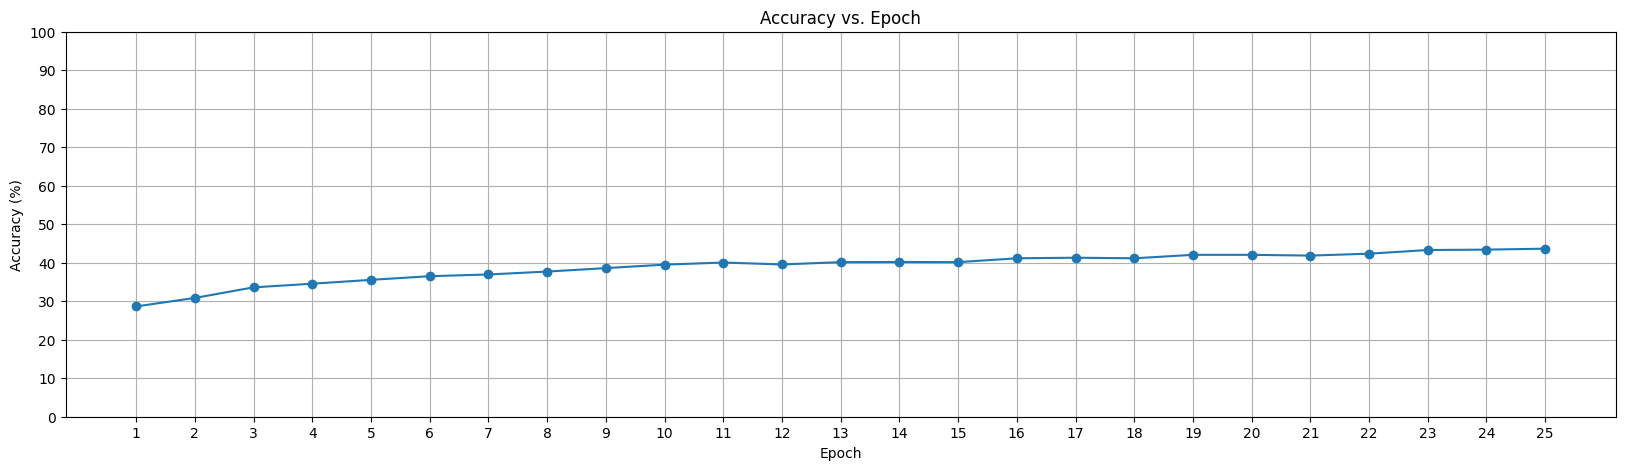

43.65

In [37]:
train_model(model,train_loader,test_loader,device)

In [ ]:


# Assuming X_train.shape[1] is defined and device is defined
dummy_input = torch.zeros(1,X_train.shape[1]).to(device)  # Move dummy_input to the same device as the model
model.to(device)

# Visualize the model using torchviz
model_vis = make_dot(model(dummy_input), params=dict(model.named_parameters()))
model_vis.render("neural_network_visualization_mlp", format="png", view=True)

# Assuming num_classes is defined
summary(model, input_size=dummy_input.size()[1:])  # Correctly specifying input_size as a tuple
